In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [87]:
lang_codes = ["ja", "ko", "tr", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = load_aggregated("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
hofstede

,pdi,idv,mas,uai,ltowvs,ivr
ctr,,,,,,
DEN,18,74,16,23,35,70
FIN,33,63,26,59,38,57
FRA,68,71,43,86,63,48
GER,35,67,66,65,83,40
ITA,50,76,70,75,61,30
JPN,54,46,95,92,88,42
KOR,60,18,39,85,100,29
NET,38,80,14,53,67,68
NOR,31,69,8,50,35,55


In [94]:
dfs = []
codes = lang_codes + [x + '.m' for x in lang_codes]

all_data = []

for language in codes:
    language_data = agg[language]
    for topic, topic_data in language_data["topics"].items():
        for d, views in topic_data["sum"].items():
            all_data.append({"lang": language, "topic": topic, "date": d, "views": views})
df = pd.DataFrame.from_dict(all_data)

In [95]:
df_desktop = df[df.lang.apply(lambda l : l in lang_codes)]
df_mobile = df[df.lang.apply(lambda l : l[-2:] == ".m")]
df_mobile.loc[:,"lang"] = df_mobile.lang.apply(lambda l: l[:-2])

In [96]:
df = pd.concat([df_desktop, df_mobile]).groupby(["lang", "topic", "date"]).sum().reset_index()

In [97]:
df["log_views"] = np.log(df.views)

In [98]:
df.head()

,lang,topic,date,views,log_views
0,ca,Culture.Biography.Biography*,2018-01-01,68986,11.141659
1,ca,Culture.Biography.Biography*,2018-01-02,65138,11.084263
2,ca,Culture.Biography.Biography*,2018-01-03,62817,11.047981
3,ca,Culture.Biography.Biography*,2018-01-04,67250,11.116172
4,ca,Culture.Biography.Biography*,2018-01-05,57697,10.962960


In [157]:
df["weekofyear"] = df.date.dt.isocalendar().week
df["year"] = df.date.dt.isocalendar().year

## Total number of views per language

In [158]:
df.groupby("lang").views.sum().sort_values(ascending=False)

lang
ja    66697912133
de    58371904626
fr    47634003329
it    37981254279
nl     9260562325
sv     5264677265
ko     4309682617
fi     3771969379
tr     2567376186
no     2172941980
da     1811082678
sr     1729553733
ca     1103548916
Name: views, dtype: int64

## Total number of views per topic

In [159]:
df.groupby("topic").views.sum().sort_values(ascending=False).head()

topic
Culture.Biography.Biography*        25594719421
Culture.Media.Media*                21294300850
Geography.Regions.Europe.Europe*    20925804957
STEM.STEM*                          17896840671
Geography.Regions.Asia.Asia*        12689883059
Name: views, dtype: int64

## Total number of views per topic (discarding metatopics and geography topics)

In [160]:
df[df.topic.apply(lambda t: (t[-1] != "*") & (not t.startswith("Geography")))].groupby("topic").views.sum().sort_values(ascending=False).head()

topic
Culture.Sports             7077353098
Culture.Literature         6853606499
Culture.Biography.Women    5888444228
Culture.Media.Films        5051345049
Culture.Media.Music        4981860737
Name: views, dtype: int64

In [161]:
df_simple = df[df.topic.apply(lambda t: (t[-1] != "*") & (not t.startswith("Geography")))]

## General views over the year

<Axes: xlabel='date', ylabel='log_views'>

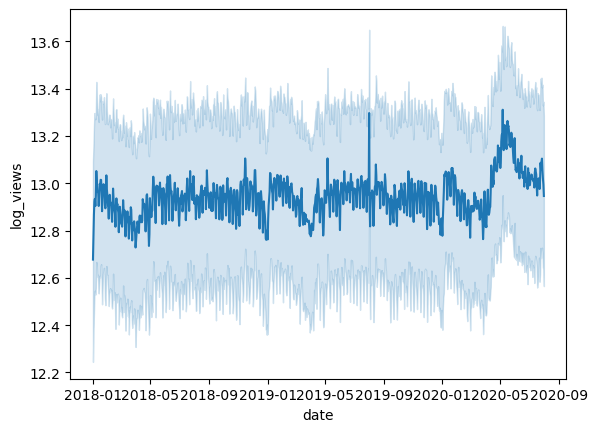

In [162]:
sns.lineplot(df_simple[df_simple.lang == "ja"], x="date", y="log_views")

<Axes: xlabel='date', ylabel='log_views'>

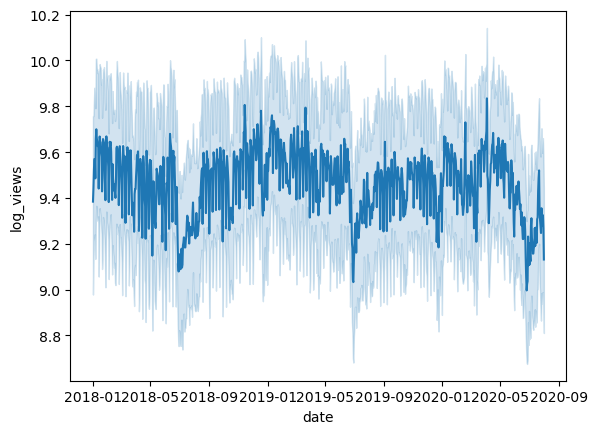

In [192]:
sns.lineplot(df_simple[df_simple.lang == "da"], x="date", y="log_views")

## Detect outliers

Outlier detection takes about 1 minute to run...

In [216]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.05, random_state=42)

def outlier_detection(x):
    clf = IsolationForest(contamination=0.05, random_state=42) 
    return clf.fit_predict(x.to_numpy().reshape((-1, 1)))

df_simple.loc[:, "valid"] = df_simple.groupby(["lang", "topic"]).views.transform(outlier_detection)

C:\Users\jybur\AppData\Local\Temp\ipykernel_8264\610286564.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple.loc[:, "valid"] = df_simple.groupby(["lang", "topic"]).views.transform(outlier_detection)


<Axes: xlabel='date', ylabel='log_views'>

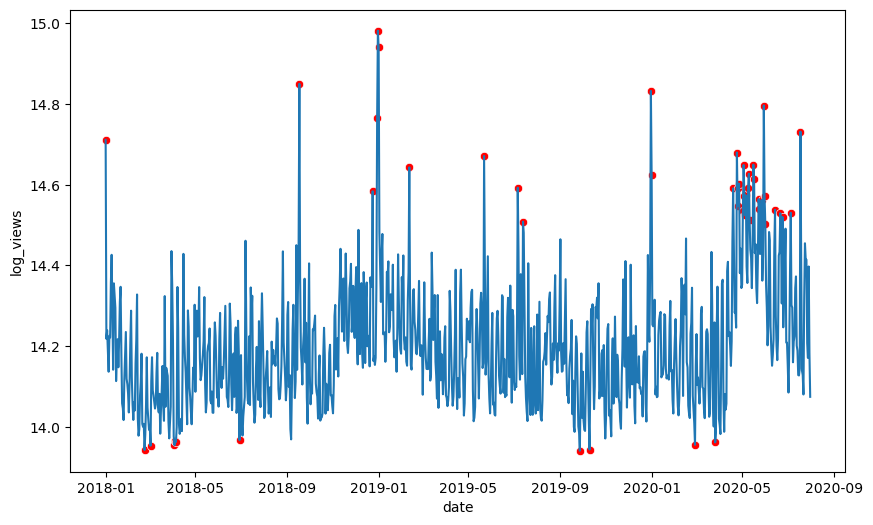

In [219]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(df_simple[(df_simple.lang == "ja") & (df_simple.topic == "Culture.Media.Music")], x="date", y="log_views", ax=ax)
sns.scatterplot(df_simple[(df_simple.lang == "ja") & (df_simple.topic == "Culture.Media.Music") & (df_simple.valid == -1)], x="date", y="log_views", ax=ax, color="red")

## Topics views over the year

<Axes: xlabel='month', ylabel='log_views'>

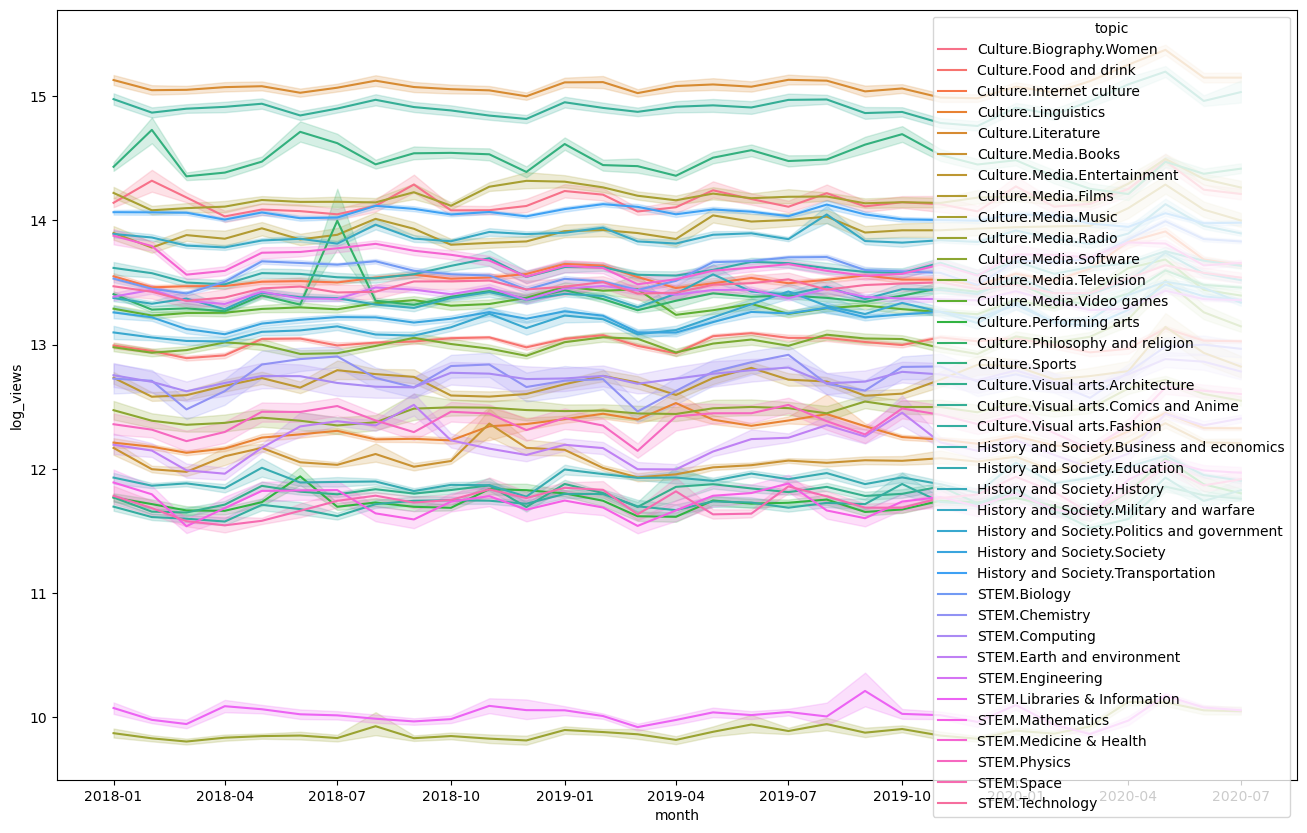

In [171]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
df_simple.loc[:,"month"] = df_simple.date.to_numpy().astype('datetime64[M]')
df_simple.loc[:,'week'] = df_simple.date - df_simple.date.dt.weekday * np.timedelta64(1, 'D')
sns.lineplot(df_simple[df_simple.lang == "ja"], x="month", y="log_views", hue="topic", legend="brief", ax=ax)

In [221]:
df_simple[df_simple.valid == 1].loc[:, "normalized_log_views"] = df_simple[df_simple.valid == 1].groupby(["lang", "topic"]).log_views.transform(lambda x : x - x.mean())

Text(0.5, 1.0, 'Trends in Japan')

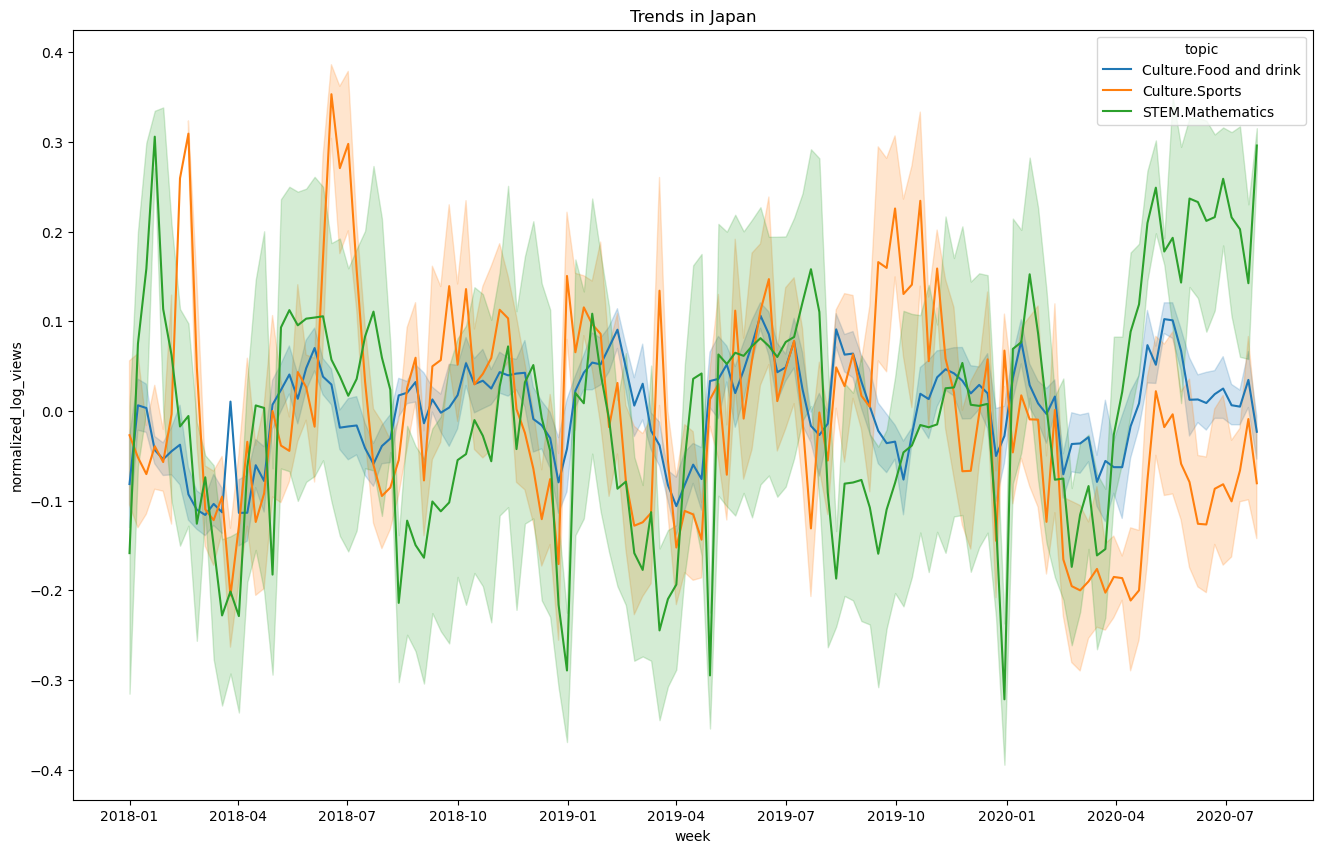

In [225]:
selected_topics = ["Culture.Food and drink", "Culture.Sports", "STEM.Mathematics"]

fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.lineplot(df_simple[(df_simple.lang == "ja") & (df_simple.valid == 1) & (df_simple.topic.apply(lambda l : l in selected_topics))], x="week", y="normalized_log_views", hue="topic", legend="brief", ax=ax)
ax.set_title("Trends in Japan")

Text(0.5, 1.0, 'Trends in Italy')

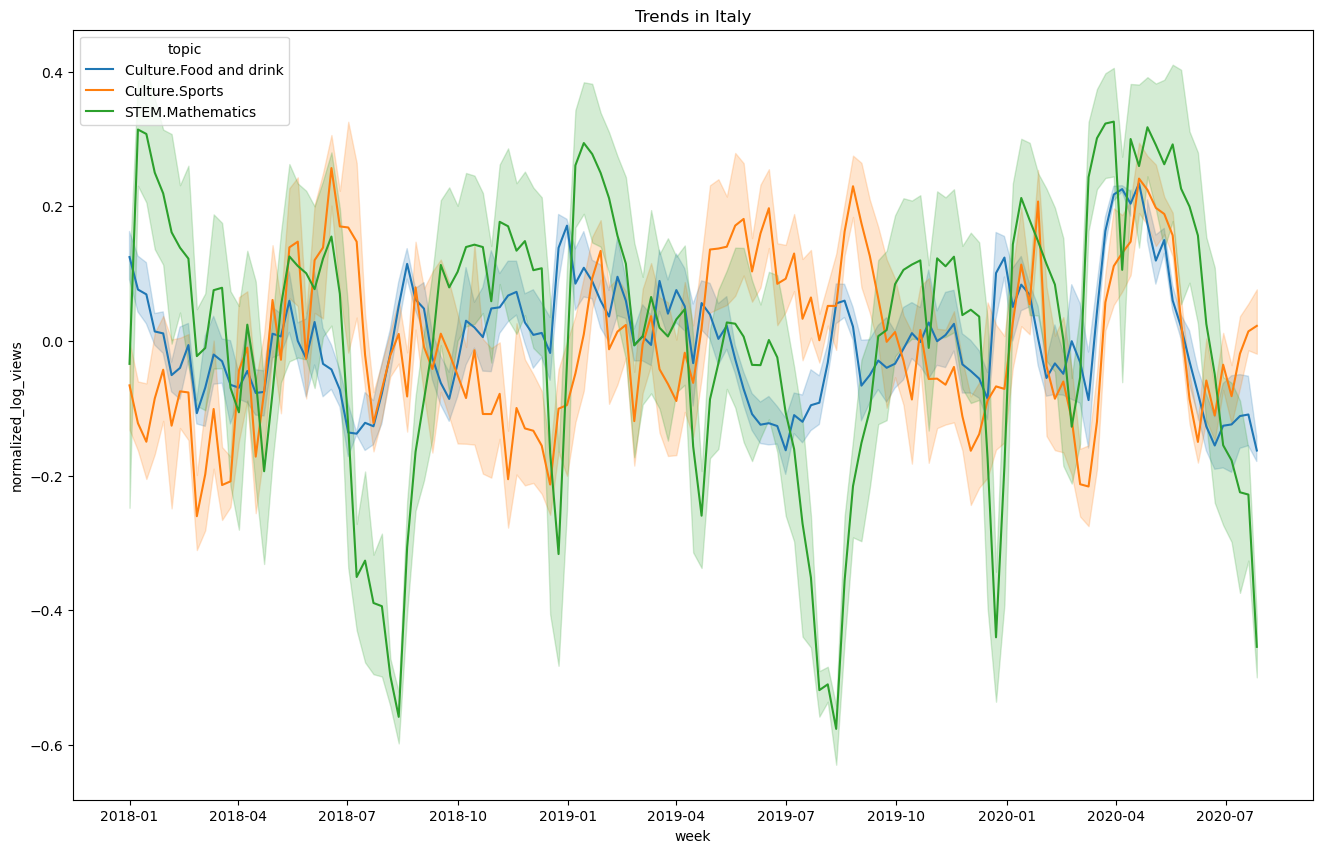

In [226]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.lineplot(df_simple[(df_simple.lang == "it") & (df_simple.valid == 1) & (df_simple.topic.apply(lambda l : l in selected_topics))], x="week", y="normalized_log_views", hue="topic", legend="brief", ax=ax)
ax.set_title("Trends in Italy")

Text(0.5, 1.0, 'Trends in Korea')

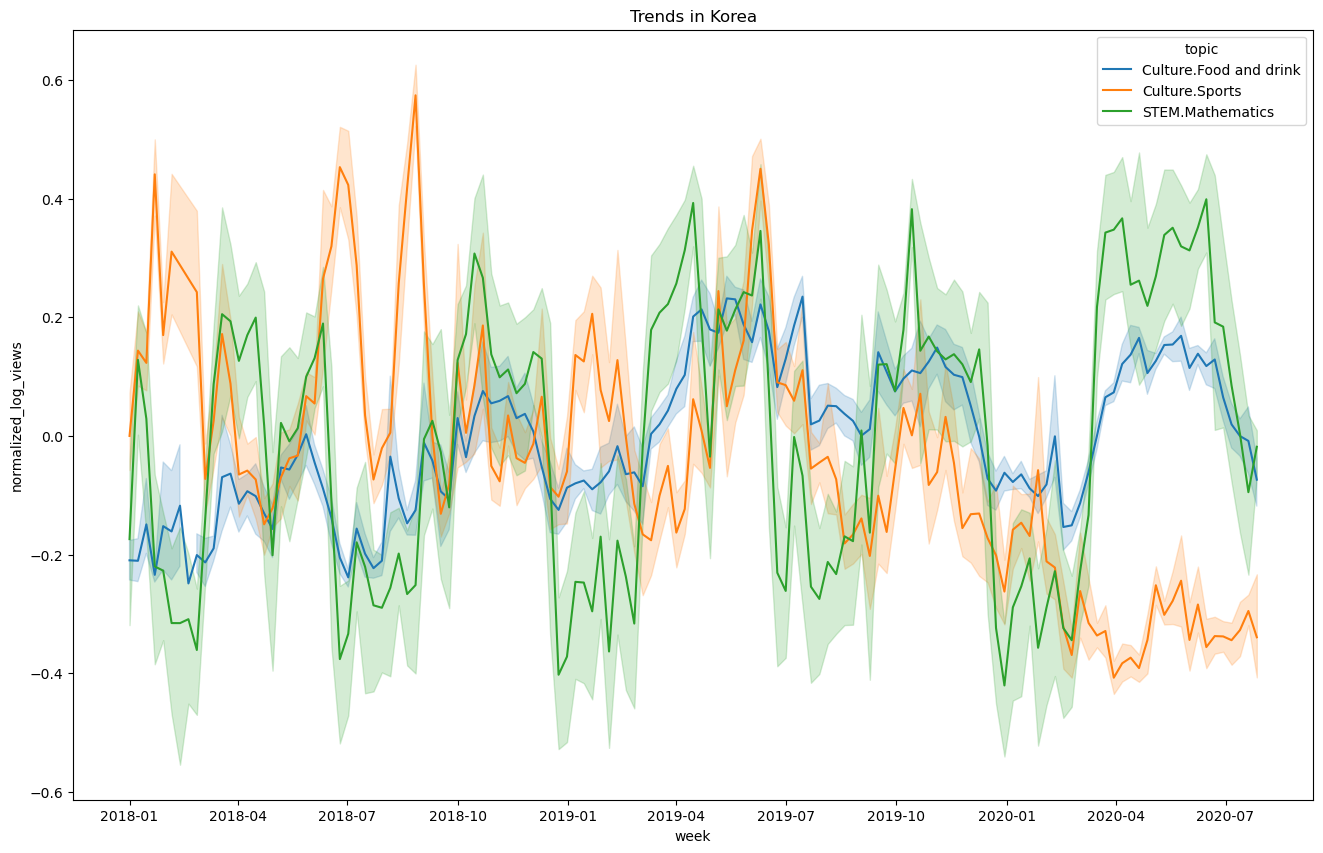

In [227]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.lineplot(df_simple[(df_simple.lang == "ko") & (df_simple.valid == 1) & (df_simple.topic.apply(lambda l : l in selected_topics))], x="week", y="normalized_log_views", hue="topic", legend="brief", ax=ax)
ax.set_title("Trends in Korea")

In [281]:
series = []
langs = df_simple.lang.unique()
data = []
for lang1 in langs:
    for lang2 in langs:
        serie1 = df_simple[(df_simple.lang == lang1) & (df_simple.topic == selected_topics[0]) & (df_simple.valid == 1)].groupby("week").normalized_log_views.mean()
        serie1 = serie1.rename(lang1)
        
        serie2 = df_simple[(df_simple.lang == lang2) & (df_simple.topic == selected_topics[0]) & (df_simple.valid == 1)].groupby("week").normalized_log_views.mean()
        serie2 = serie2.rename(lang2)
        
        merged = pd.merge(serie1, serie2, left_on="week", right_on="week", how="inner")
        data.append({"lang1": lang1, "lang2": lang2, "corr": np.array(merged.corr())[0,1]})

In [282]:
corr_df = pd.DataFrame.from_dict(data)
corr_df = pd.pivot_table(corr_df, values="corr", index="lang1", columns="lang2")

Text(0.5, 1.0, 'Time series correlation for Culture.Food and drink')

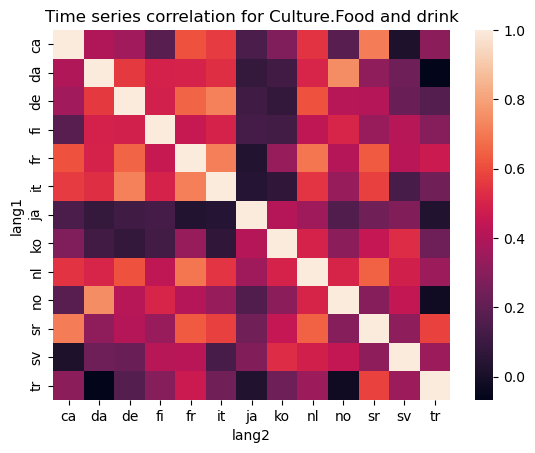

In [284]:
fig, ax = plt.subplots(1,1)
sns.heatmap(corr_df, ax=ax)
ax.set_title(f"Time series correlation for {selected_topics[0]}")

In [304]:
lang_maps = {"JPN" : "ja", "KOR": "ko", "TUR": "tr", "SWE": "sv", "NOR": "no", "FIN": "fi", "DEN": "da", "SER": "sr", "ITA": "it", "SPA": "ca", "NET": "nl", "FRA": "fr", "GER": "de"}
lang_maps_inv = {}
for c,l in lang_maps.items():
    lang_maps_inv[l] = c

In [328]:
hof_data = []

for lang1 in lang_codes:
    for lang2 in lang_codes:
        e1 = hofstede.loc[lang_maps_inv[lang1],:].to_numpy()
        e2 = hofstede.loc[lang_maps_inv[lang2],:].to_numpy()

        hof_data.append({"lang1": lang1, "lang2": lang2, "hof_dist": -np.linalg.norm(e1-e2)})

hof_pd = pd.DataFrame.from_dict(hof_data)
hof_pd = hof_pd.pivot_table(values="hof_dist", index="lang1", columns="lang2")

Text(0.5, 1.0, 'Hofstede score')

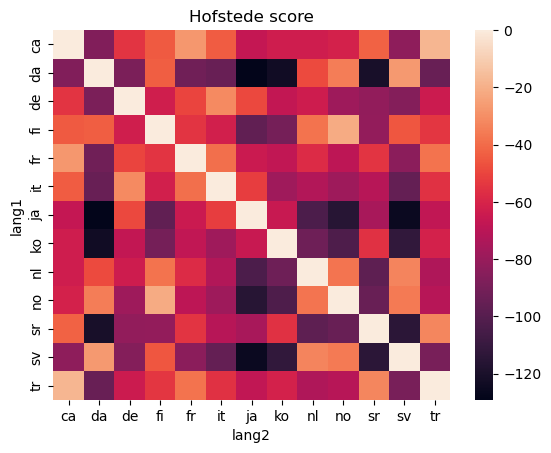

In [329]:
fig, ax = plt.subplots(1,1)
sns.heatmap(hof_pd, ax=ax)
ax.set_title(f"Hofstede score")